## Scan of camera lens  

In [1]:
import matplotlib.pyplot as plt
import numpy as np
raw_fpath = '/data02/MyArchive/tomo_datasets/lens/lens1_184.h5'
rec_fpath = '/data02/MyArchive/tomo_datasets/lens/reconstructed_gray'
seg_fpath = '/data02/MyArchive/tomo_datasets/lens/reconstructed_bin'
pg_dict = {"alpha" : 0.00005, "energy" : 30.0, "detector_dist_cm" : 15.0, "pixel_size_um" : 3.13, "pg_pad" : 10}

## Find Center  
Center finding can be done using MSE (uses cupy) or NCC (uses skimage match_template) metrics  

In [2]:
from tomo2mesh.misc import find_center

In [3]:
pair = find_center.read_opposing_pairs(raw_fpath)
search_width = 20 # 20 pixels on left and 20 on right of guessed center
_, nz, n = pair.shape
center_guess = n//2
search_range = (center_guess - search_width, center_guess + search_width)
center = find_center.estimate_center(pair, search_range, roi_width = 0.8, metric = "MSE", roi_height = (0,1))
print(f"found center at {center}")

found center at 1224


## Read and reconstruct raw data from dxchange file  
Raw data can be read as a set of projections, theta, dark, flat. A helper function is provided if data is in dxchange format. Then, you may reconstruct a slice or a full volume. A viewer module is provided for easily viewing reconstructed and segmented slices.  

In [4]:
from tomo2mesh.misc.rw_dxchange import read_raw_data_any
from tomo2mesh.fbp.recon import recon_slice, recon_binned, recon_all
from tomo2mesh.misc import viewer

In [5]:
projs, theta, dark, flat = read_raw_data_any(raw_fpath)

In [6]:
img = recon_slice(projs, theta, center, dark, flat, 0.5, pg_dict = pg_dict)

data shape: (ntheta, nz, n) (1500, 21, 2448)


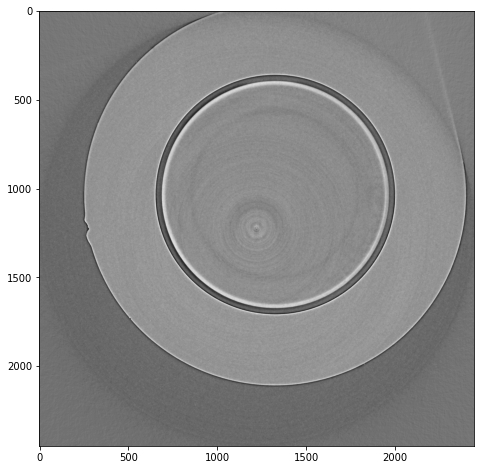

In [7]:
fig, ax = plt.subplots(1,1, figsize = (8,8))
ax.imshow(img, cmap = 'gray')

In [8]:
vol = recon_all(projs, theta, center, 32, dark, flat, pg_dict = pg_dict, outlier_removal = True)

100%|███████████████████████████████████████████| 36/36 [01:46<00:00,  2.94s/it]


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

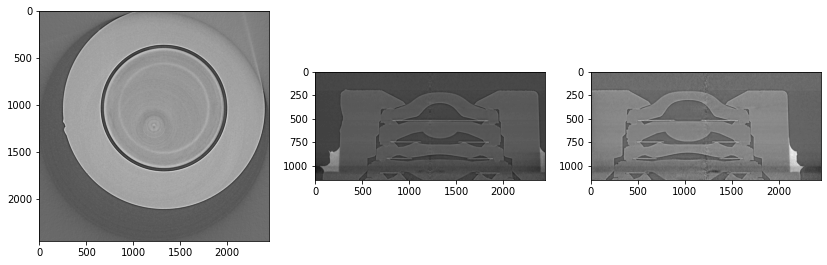

In [9]:
fig, ax = plt.subplots(1,3, figsize = (14,8))
viewer.view_midplanes(vol = vol, ax = ax)

## Segmentation  
This segmentation can be attempted using a custom Otsu implementation which takes data inside a cylindrical FOV for determining the threshold. Some artifacts are observed so there is room for improvement.  

In [10]:
from tomo2mesh.misc.otsu import otsu_cyl_mask

In [11]:
volb = otsu_cyl_mask(vol, 0.6, apply_mask_frac = 0.95, inverted = False) # fraction of cylindrical mask. Chose 0.6 to avoid including the bright piece of (possibly metal?) on the periphery in calculating threshold.

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

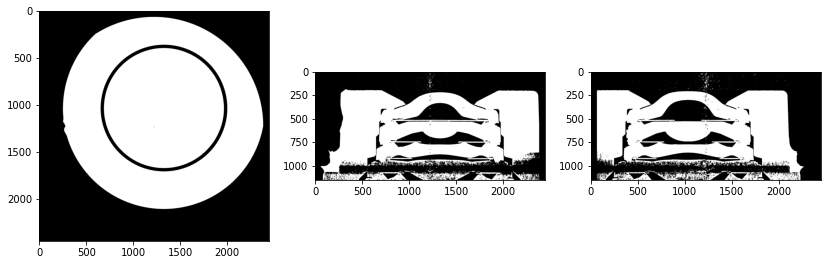

In [12]:
fig, ax = plt.subplots(1,3, figsize = (14,8))
viewer.view_midplanes(vol = volb, ax = ax)

## Plot nice image slices  

In [13]:
from tomo2mesh.misc.voxel_processing import modified_autocontrast
pixel_size_um = pg_dict["pixel_size_um"]

In [14]:
imx = viewer.get_orthoplanes(vol = vol, idxs = None) # provide a list of three indices (z, y, x) for custom slices  
imb = viewer.get_orthoplanes(vol = volb)

<AxesSubplot:>

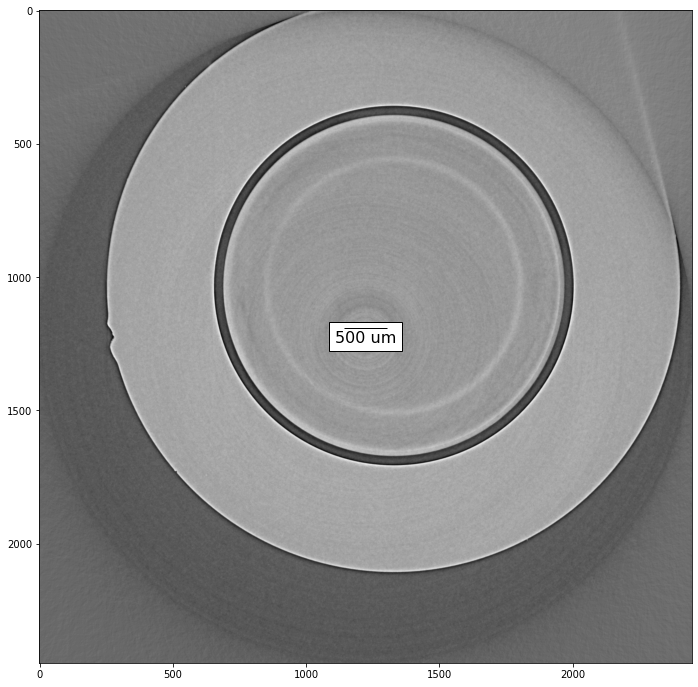

In [15]:
fig, ax = plt.subplots(1,1,figsize = (12,12))
ax.imshow(imx[0], cmap = 'gray')
viewer.add_scalebar(ax, 500, pixel_size_um, units = 'um', loc="center")

<AxesSubplot:>

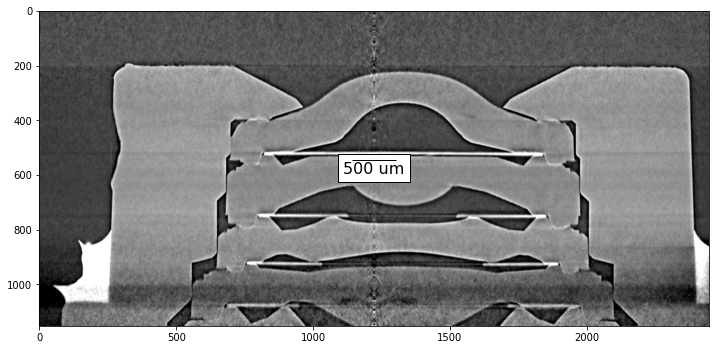

In [16]:
fig, ax = plt.subplots(1,1,figsize = (12,12))
h = modified_autocontrast(imx[1])
ax.imshow(np.clip(imx[1], *h), cmap = 'gray')
viewer.add_scalebar(ax, 500, pixel_size_um, units = 'um', loc="center")

<AxesSubplot:>

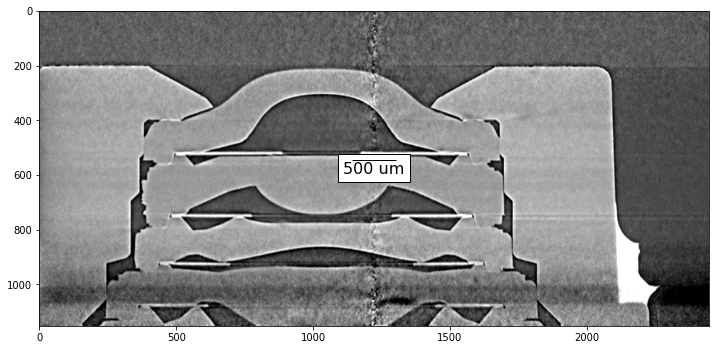

In [17]:
fig, ax = plt.subplots(1,1,figsize = (12,12))
h = modified_autocontrast(imx[2])
ax.imshow(np.clip(imx[2], *h), cmap = 'gray')
viewer.add_scalebar(ax, 500, pixel_size_um, units = 'um', loc="center")

<AxesSubplot:>

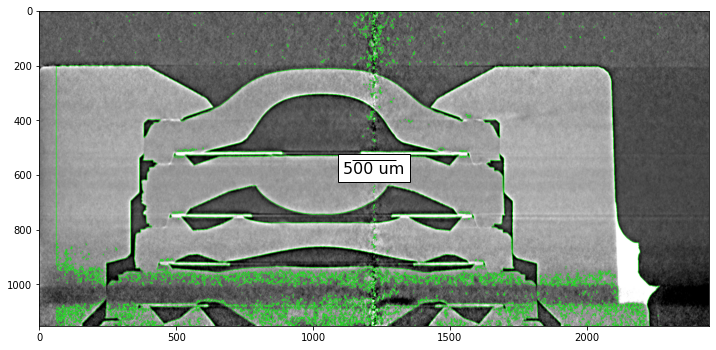

In [18]:
fig, ax = plt.subplots(1,1,figsize = (12,12))
h = modified_autocontrast(imx[2])
viewer.edge_plot(np.clip(imx[2], *h), imb[2], ax = ax)
viewer.add_scalebar(ax, 500, pixel_size_um, units = 'um', loc="center")

## Saving data  
Saving and reading reconstructed / segmented 3D volumes can be done using DataFile class. To save disk memory, we can normalize and convert reconstructed volume into 16-bit. Normalize function provided uses cupy for fast pixel operations. Conversion of grayscale to 16-bit will result in lossy compression.    

In [19]:
from tomo2mesh import DataFile
from tomo2mesh.misc.voxel_processing import normalize_volume_gpu
vol = (normalize_volume_gpu(vol)*(2**16-1)).astype(np.uint16)

In [20]:
dfile = DataFile(rec_fpath, tiff = True, d_shape = vol.shape, d_type = vol.dtype)
dfile.create_new(overwrite=True)
dfile.write_full(vol)
dfile.show_stats()

Removed old contents in tiff folder reconstructed_gray

Dataset shape: (1152, 2448, 2448)
Dataset size: 13.81 GB
Slice size along 0: 11.99 MB
Slice size along 1: 5.64 MB
Slice size along 2: 5.64 MB


In [21]:
dfile = DataFile(seg_fpath, tiff = True, d_shape = volb.shape, d_type = volb.dtype)
dfile.create_new(overwrite=True)
dfile.write_full(volb)
dfile.show_stats()

Removed old contents in tiff folder reconstructed_bin

Dataset shape: (1152, 2448, 2448)
Dataset size: 6.90 GB
Slice size along 0: 5.99 MB
Slice size along 1: 2.82 MB
Slice size along 2: 2.82 MB
